# Kaggle competition: Forest Cover Type Prediction

In this competition, the task is to predict the forest cover type (the predominant kind of tree cover) from cartographic variables. Each observation in our dataset corresponds to a $30\textrm{m} \times 30\textrm{m}$ patch of land located in the Roosevelt National Forest of northern Colorado. There are seven possible forest cover types:

**1. Spruce/Fir** <br>
**2. Lodgepole Pine** <br>
**3. Ponderosa Pine** <br> 
**4. Cottonwood/Willow** <br>
**5. Aspen** <br>
**6. Douglas-fir** <br>
**7. Krummholz** <br>

The training dataset for this Kaggle competition consists of $15120$ samples with $56$ features (a mixture of both continuous and categorical data), including the **Cover_Type** represented by an integer $\{1,2,3,4,5,6,7\}$. Our task is to classify test samples by cover type (i.e. this is a multi-class classification task).

## 1. Import libraries:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 2. Data description:

First, let's read the training data into a pandas dataframe:

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


We can first check for missing (null) values in our dataset:

In [3]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

There are no missing values. Let us drop the **id** identifier for each row:

In [4]:
df = df.drop(["Id"], axis=1)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


The dataset contains a mix of categorical and continuous variables as shown below.

In [5]:
categorical_variables = ["Cover_Type", "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30",  "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"]
continuous_variables = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]
continuous_variables_labels = ["Elevation", "Aspect", "Slope", "Horizontal Dist. To Hydrology", "Vertical Dist. To Hydrology", "Horizontal Dist. To Roadways", "Horizontal Dist. To Fire Points", "Hillshade 9am", "Hillshade Noon", "Hillshade 3pm"]

print(f'There are {len(categorical_variables)} categorical variables.')
print(f'There are {len(continuous_variables)} continuous variables.')

There are 45 categorical variables.
There are 10 continuous variables.


## 3. Exploratory Data Analysis:

### 3.1 Cover types by wilderness area:

Let's check how many samples of each cover type there are. It seems have equal numbers of each type $(2160)$ in our training set (note the train/test split is made for us by Kaggle for this competition):  

In [6]:
cover_type_counts = np.asarray(df.groupby(["Cover_Type"]).size())
cover_type_counts

array([2160, 2160, 2160, 2160, 2160, 2160, 2160], dtype=int64)

Each sample is taken from one of four wilderness areas. Let's look at where each of the $7$ cover types are found:

In [7]:
area_1_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area1"])
area_2_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area2"])
area_3_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area3"])
area_4_counts = np.asarray(df.groupby(["Cover_Type"]).sum()["Wilderness_Area4"])

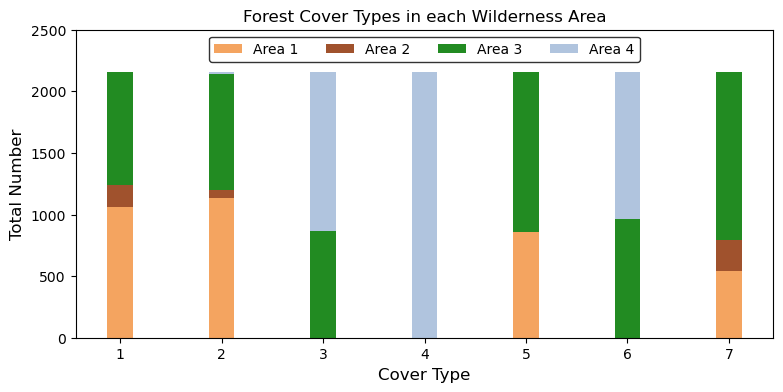

In [8]:
plt.figure(figsize=(9, 4))
p1 = plt.bar(range(1,8), area_1_counts, width=0.25, color='sandybrown', label="Area 1")
p2 = plt.bar(range(1,8), area_2_counts, width=0.25, bottom=area_1_counts, color='sienna', label="Area 2")
p3 = plt.bar(range(1,8), area_3_counts, width=0.25, bottom=area_1_counts+area_2_counts, color='forestgreen', label="Area 3")
p4 = plt.bar(range(1,8), area_4_counts, width=0.25, bottom=area_1_counts+area_2_counts+area_3_counts, color='lightsteelblue', label="Area 4")
plt.ylim([0, 2500])
plt.legend(ncol=4, loc="upper center", frameon=True, edgecolor='k')
plt.xlabel("Cover Type", fontsize=12)
plt.ylabel("Total Number", fontsize=12)
plt.title("Forest Cover Types in each Wilderness Area", fontsize=12)
plt.show()

### 3.2 Distributions of continuous variables per cover type:

Let's look at the distributions of the different cover types with respect to each of the continuous variables.

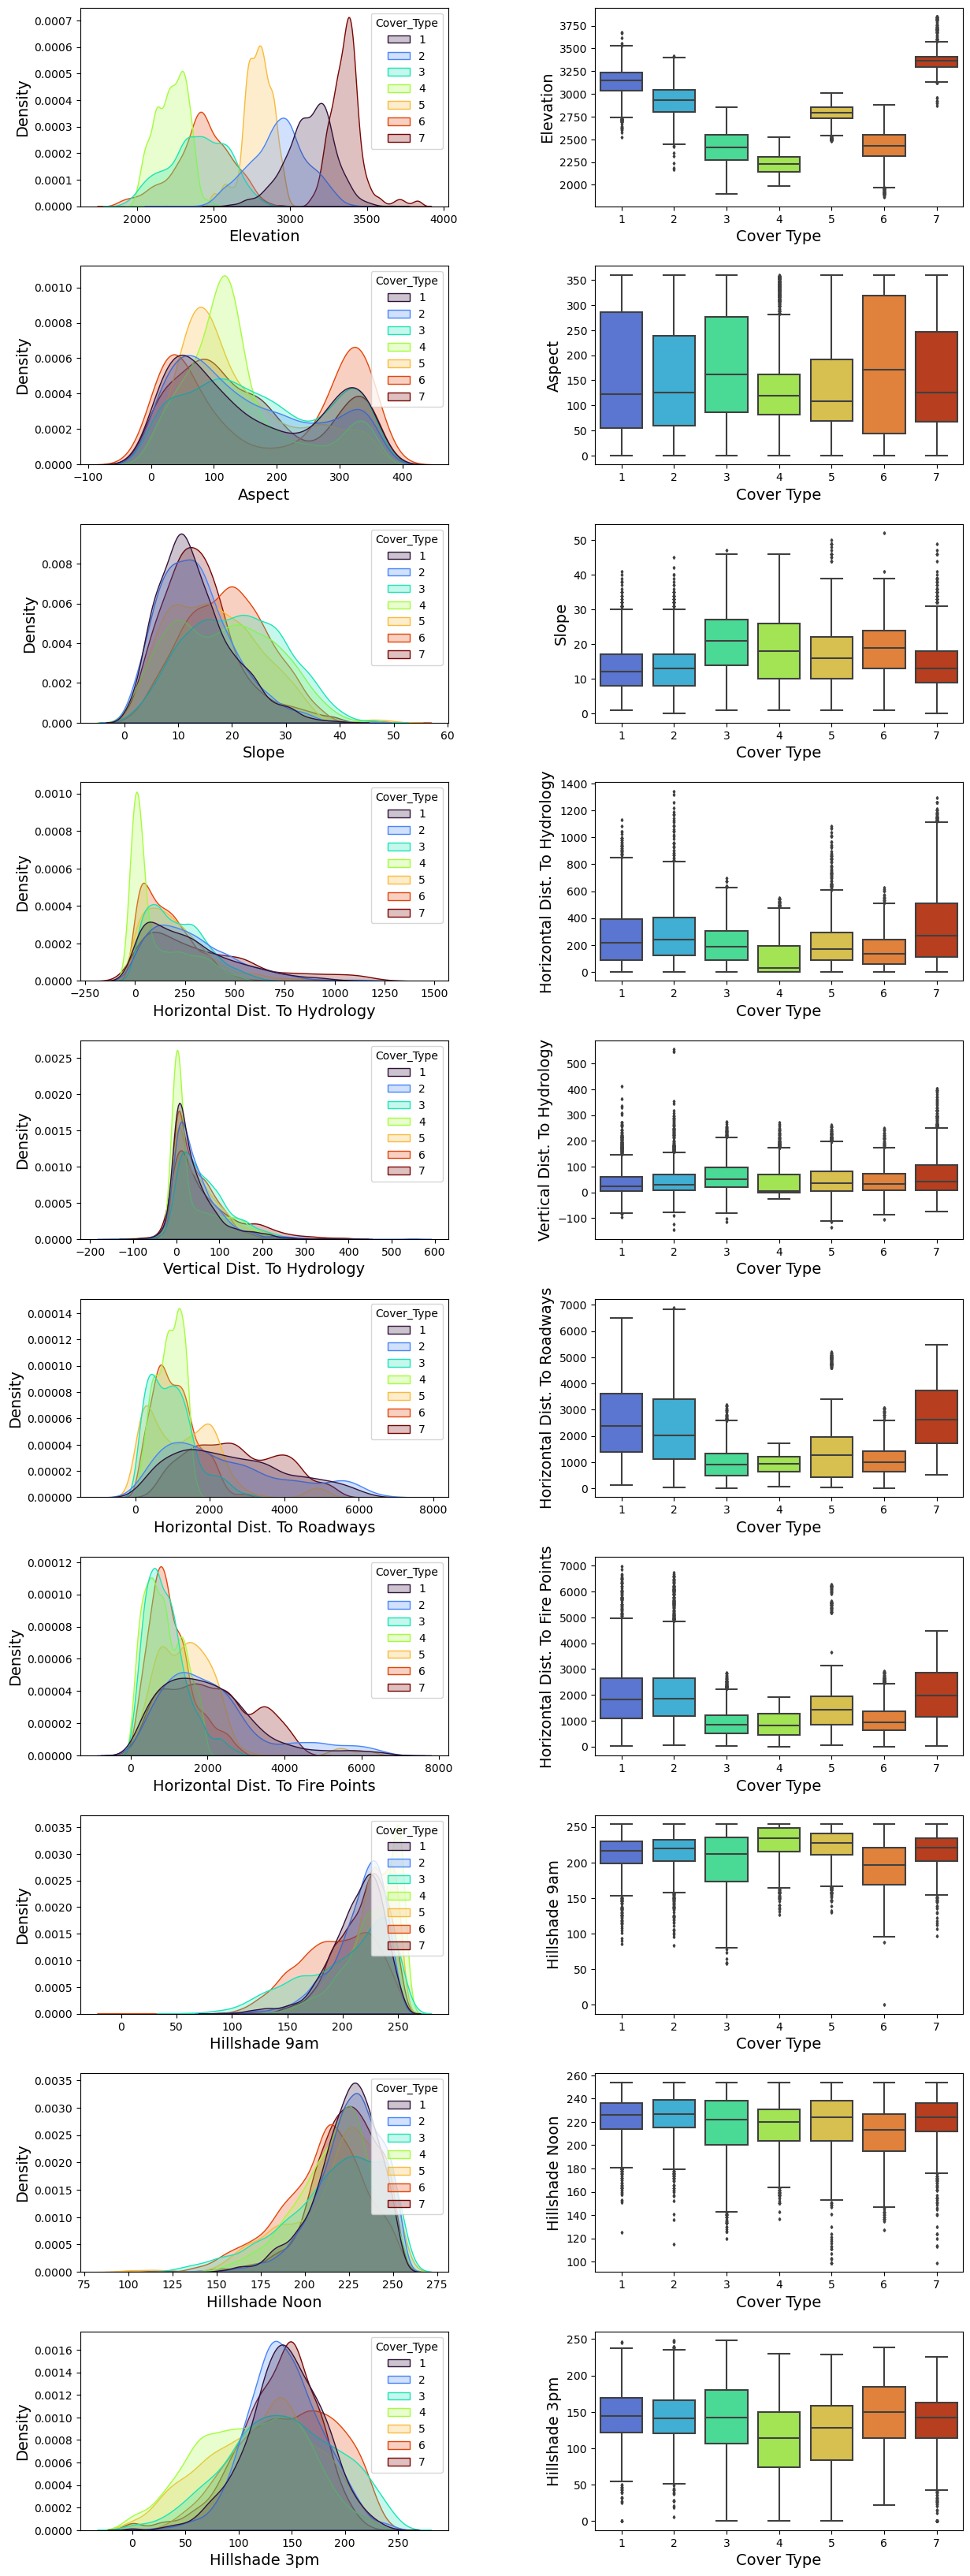

In [9]:
fig, axs = plt.subplots(10, 2, figsize=(14,40))

for i in range(len(continuous_variables)):
    
    sns.kdeplot(data=df, x=continuous_variables[i], hue='Cover_Type', palette='turbo', fill=True, ax=axs[i][0])
    sns.boxplot(data=df, y=continuous_variables[i], x='Cover_Type', palette='turbo', fliersize=2, ax=axs[i][1])
    
    axs[i][0].set_xlabel(continuous_variables_labels[i], fontsize=14)
    axs[i][1].set_ylabel(continuous_variables_labels[i], fontsize=14)
    axs[i][1].set_xlabel('Cover Type', fontsize=14)
    axs[i][0].set_ylabel('Density', fontsize=14)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

plt.show()


### 3.3 Soil type frequency:

There are 40 distinct soil types, each represented by a binary variable ($1$ or $0$) depending on if a particular soil type is present. For each of the $7$ types of forest cover, we can look at the most common soil types: 

In [10]:
cover_df = df.groupby('Cover_Type').sum()

soil_1 =  np.array([cover_df['Soil_Type'+str(i)][1] for i in range(1,41)])
soil_2 =  np.array([cover_df['Soil_Type'+str(i)][2] for i in range(1,41)])
soil_3 =  np.array([cover_df['Soil_Type'+str(i)][3] for i in range(1,41)])
soil_4 =  np.array([cover_df['Soil_Type'+str(i)][4] for i in range(1,41)])
soil_5 =  np.array([cover_df['Soil_Type'+str(i)][5] for i in range(1,41)])
soil_6 =  np.array([cover_df['Soil_Type'+str(i)][6] for i in range(1,41)])
soil_7 =  np.array([cover_df['Soil_Type'+str(i)][7] for i in range(1,41)])

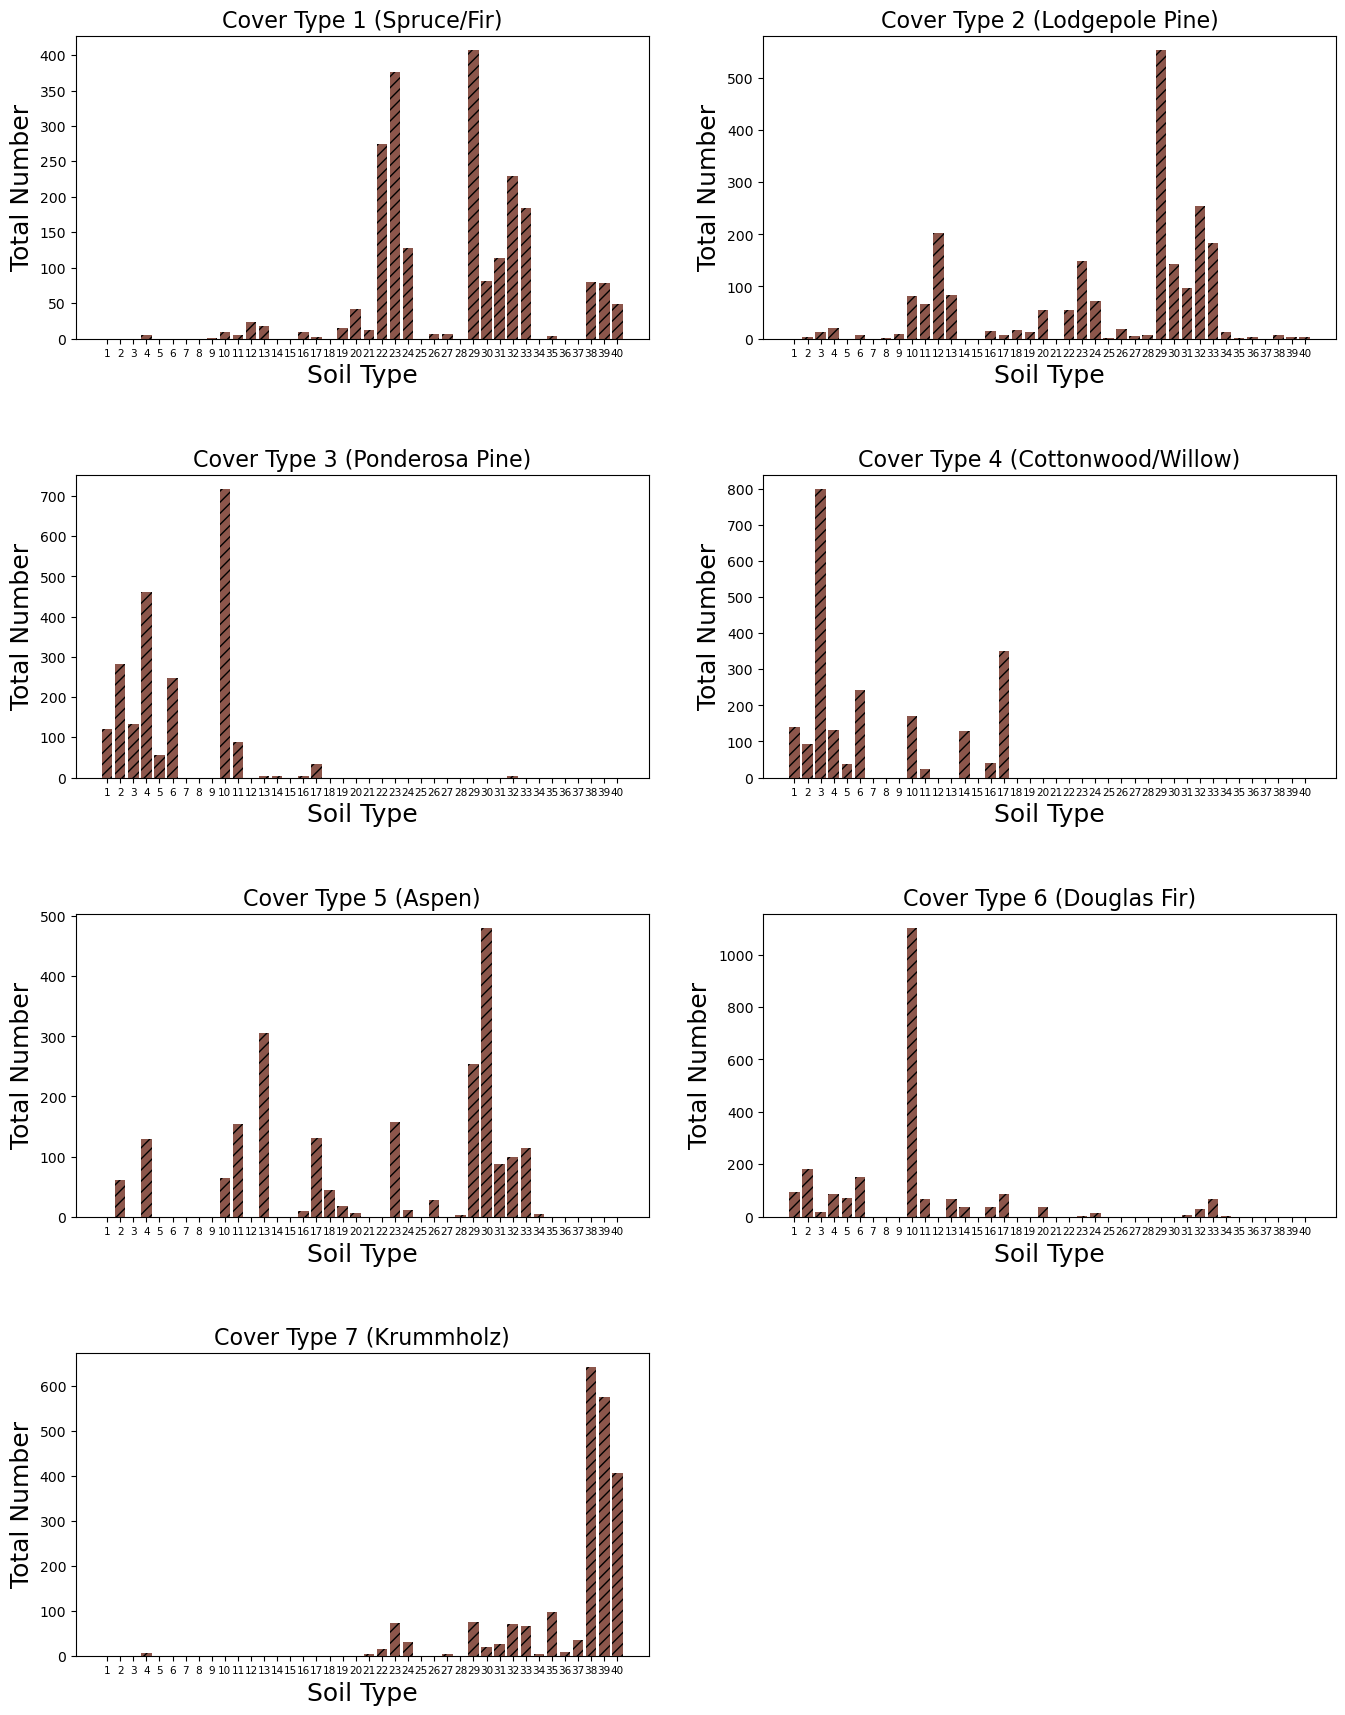

In [11]:
fig, axs = plt.subplots(4,2, figsize=(14, 18))

axs[0][0].bar(x=list(range(1,41)), height=soil_1, hatch='///', color='tab:brown')
axs[0][1].bar(x=list(range(1,41)), height=soil_2, hatch='///', color='tab:brown')
axs[1][0].bar(x=list(range(1,41)), height=soil_3, hatch='///', color='tab:brown')
axs[1][1].bar(x=list(range(1,41)), height=soil_4, hatch='///', color='tab:brown')
axs[2][0].bar(x=list(range(1,41)), height=soil_5, hatch='///', color='tab:brown')
axs[2][1].bar(x=list(range(1,41)), height=soil_6, hatch='///', color='tab:brown')
axs[3][0].bar(x=list(range(1,41)), height=soil_7, hatch='///', color='tab:brown')
axs[3][1].axis('off')

axs[0][0].set_title('Cover Type 1 (Spruce/Fir)', fontsize=16)
axs[0][1].set_title('Cover Type 2 (Lodgepole Pine)', fontsize=16)
axs[1][0].set_title('Cover Type 3 (Ponderosa Pine)', fontsize=16)
axs[1][1].set_title('Cover Type 4 (Cottonwood/Willow)', fontsize=16)
axs[2][0].set_title('Cover Type 5 (Aspen)', fontsize=16)
axs[2][1].set_title('Cover Type 6 (Douglas Fir)', fontsize=16)
axs[3][0].set_title('Cover Type 7 (Krummholz)', fontsize=16)

for i in range(4):
    for j in range(2):
        axs[i][j].set_xticks(list(range(1,41)))
        axs[i][j].set_xticklabels(labels=list(range(1,41)), fontsize=7.5)
        axs[i][j].set_xlabel('Soil Type', fontsize=18)
        axs[i][j].set_ylabel('Total Number', fontsize=18)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.45)

plt.show()

### 3.4 Correlation heatmap:

It is also useful to produce a correlation heatmap for our continuous variables, such as <b>Elevation</b> and <b>Slope</b>:

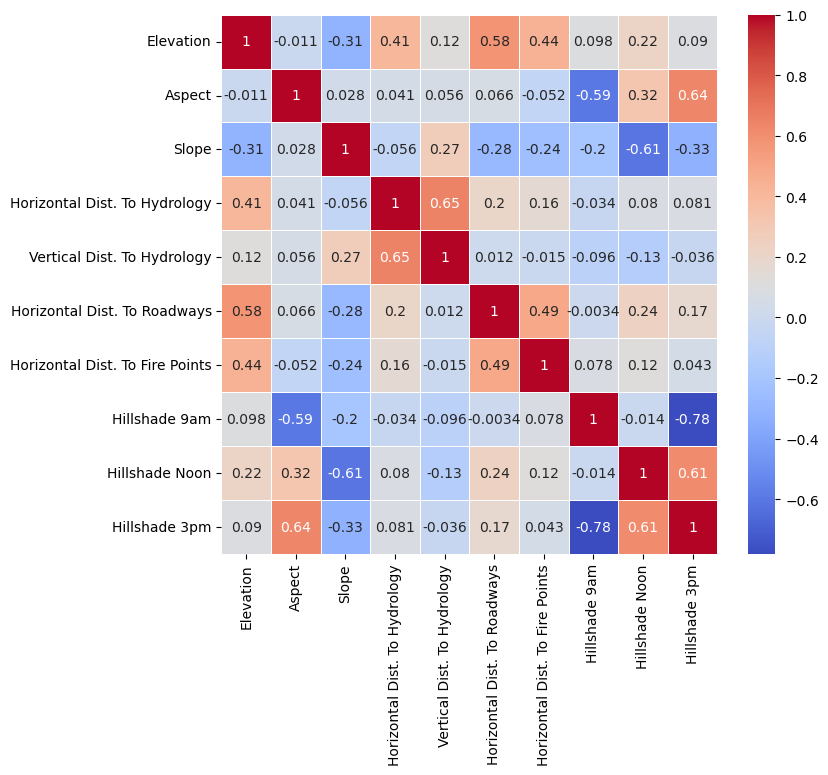

In [12]:
plt.figure(figsize=(8,7))
corr = df[continuous_variables].corr()
sns.heatmap(corr, xticklabels=continuous_variables_labels, yticklabels=continuous_variables_labels, linewidths=0.5, cmap='coolwarm', annot=True)
plt.show()

Our distribution plots clearly show that <b>Elevation</b> is quite important when it comes to statifiying the $7$ cover types. For example, Krummholz (class $7$) is evidently found at high elevation, with practically all observations occuring at elevations above $3000\textrm{m}$. Its elevation distribution has no overlap with the lowest lying type, which is Cottonwood/Willow (class $4$), which is mainly found below $2500\textrm{m}$.

Some of continuous features seem to have little correlation with one another, e.g. <b>Elevation</b> and <b>Vertical_Distance_To_Hydrology</b>. However, we can ask whether a jointplot of these variables, <i>distinguishing data points by their cover type</i>, could reveal any hidden structure.  

### 3.5 Jointplots of continuous variables:

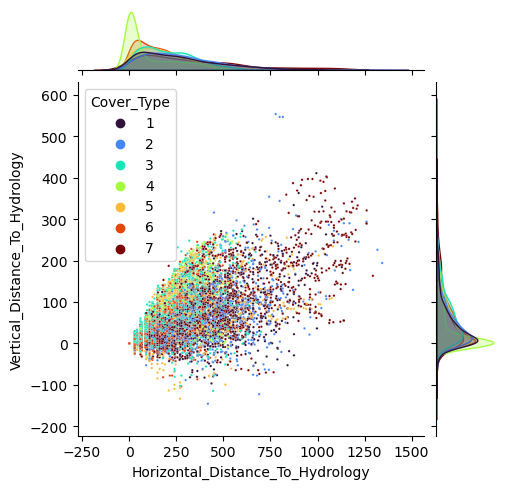

In [13]:
# Plot "Vertical_Distance_To_Hydrology" vs "Horizontal_Distance_To_Hydrology"

sns.jointplot(data=df, x="Horizontal_Distance_To_Hydrology", y="Vertical_Distance_To_Hydrology", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

There is a strong positive correlation of $0.65$ between <b>Vertical_Distance_To_Hydrology</b> and <b>Horizontal_Distance_To_Hydrology</b>, as one might expect. It may be useful to engineer a feature representing the total distance to hydology by combining the squares of these variables.

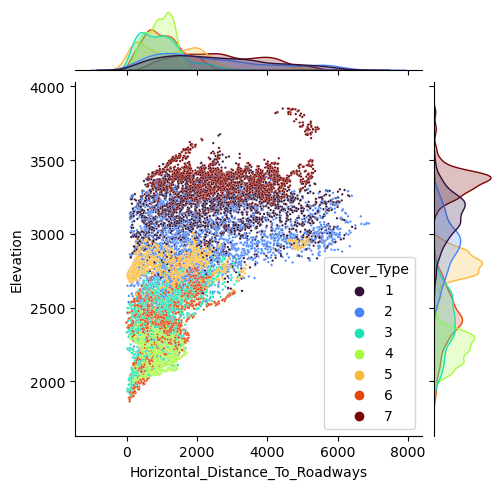

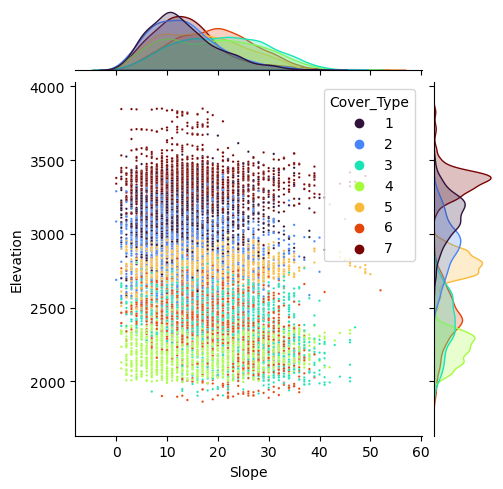

In [14]:
# Plot "Elevation" vs "Horizontal_Distance_To_Roadways"

sns.jointplot(data=df, x="Horizontal_Distance_To_Roadways", y="Elevation", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

# Plot "Elevation" vs "Slope"

sns.jointplot(data=df, x="Slope", y="Elevation", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()


These jointplots illustrate how <b>Elevation</b> is a useful feature for separating the different cover types. Other continuous variables such as <b>Slope</b> may not be as useful since for any given slope, e.g. 20 degrees, we observe examples of essentially all cover types. However, other continuous features such as <b>Horizontal_Distance_To_Roadways</b> also separate cover types somewhat, e.g. all Cottonwood/Willow (class $4$) observations are within $2000\textrm{m}$ horizontally from a roadway, while classes $1$, $2$, and $7$ have flatter distributions over a range reaching over $6000\textrm{m}$.

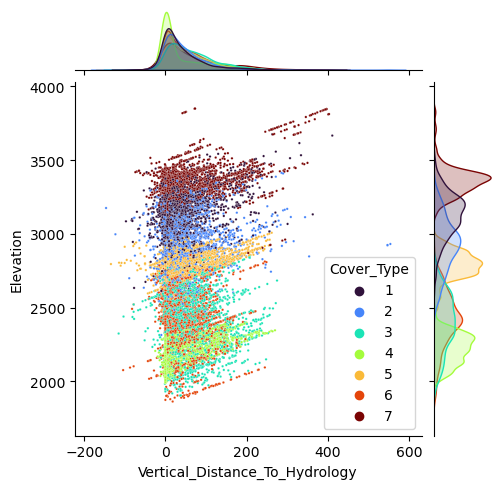

In [15]:
# Plot "Elevation" vs "Vertical_Distance_To_Hydrology"

sns.jointplot(data=df, x="Vertical_Distance_To_Hydrology", y="Elevation", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

In the above jointplot, we plot <b>Elevation</b> against <b>Vertical_Distance_To_Hydrology</b>, distinguishing by cover type. According to our correlation matrix, there is little correlation ($0.12$) between these variables when one combines data for all cover types. However, if we distinguish by cover type, we begin to see some structure. It appears that there are distinct sets of observations which fall along lines of positive slope, with each set belonging to a particular cover type.  

We can consider engineering new features which are linear combinations of two features. For example, defining a feature which is the <i>sum</i> of <b>Elevation</b> and <b>Vertical_Distance_To_Hydrology</b> may help stratify the data by cover type better than <b>Vertical_Distance_To_Hydrology</b> alone. 

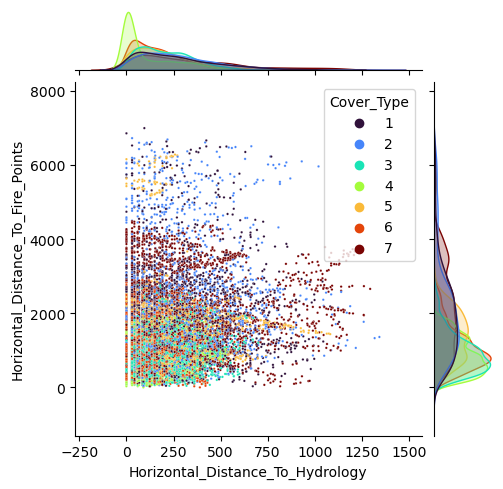

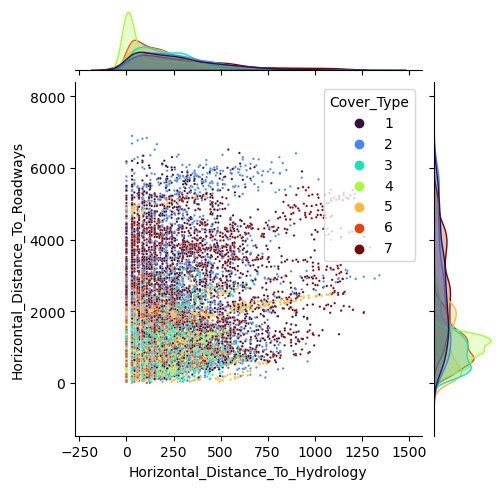

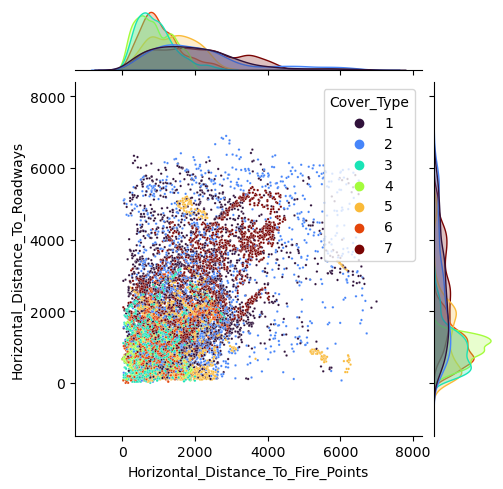

In [16]:
# Plot "Horizontal_Distance_To_Fire_Points" vs "Horizontal_Distance_To_Hydrology"

sns.jointplot(data=df, x="Horizontal_Distance_To_Hydrology", y="Horizontal_Distance_To_Fire_Points", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

# Plot "Horizontal_Distance_To_Roadways" vs "Horizontal_Distance_To_Hydrology"

sns.jointplot(data=df, x="Horizontal_Distance_To_Hydrology", y="Horizontal_Distance_To_Roadways", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

# Plot "Horizontal_Distance_To_Roadways" vs "Horizontal_Distance_To_Fire_Points"

sns.jointplot(data=df, x="Horizontal_Distance_To_Fire_Points", y="Horizontal_Distance_To_Roadways", hue="Cover_Type", palette='turbo', height=5, s=3)
plt.show()

Again, the above jointplots appear to show that there are distinct sets of observations which fall along lines of positive or negative slope, with each set belonging to a particular cover type. In the following section, we will experiment with engineering features that are linear combinations of others, which we shall see helps us achieve higher accuracy on this classification task.  

## 4. Feature Engineering:

In [17]:
df.head(20)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
5,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
6,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
7,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
8,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5
9,2612,59,10,247,11,636,228,219,124,6230,...,0,0,0,0,0,0,0,0,0,5


As we discussed above, we will engineer some new features such as the total distance to hydrology. We will also use linear combinations of features, such as <b>Elevation</b> + <b>Vertical_Distance_To_Hydrology</b> (which has a natural interpretation i.e. the elevation from sea level of the nearest surface water feature from the actual observation site). 

In [18]:
df['Total_Distance_To_Hydrology'] = (df['Vertical_Distance_To_Hydrology']**2 + df['Horizontal_Distance_To_Hydrology']**2)**0.5

df['Elevation_Plus_Vertical_Hydrology'] = df['Elevation'] + df['Vertical_Distance_To_Hydrology']
df['Elevation_Minus_Vertical_Hydrology'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology']

df['Hydrology_Plus_Fire_Points'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
df['Hydrology_Minus_Fire_Points'] = df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points']

df['Hydrology_Plus_Roadways'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways']
df['Hydrology_Minus_Roadways'] = df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways']

df['Fire_Points_Plus_Roadways'] = df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways']
df['Fire_Points_Minus_Roadways'] = df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways']

In [19]:
df.head(20)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Cover_Type,Total_Distance_To_Hydrology,Elevation_Plus_Vertical_Hydrology,Elevation_Minus_Vertical_Hydrology,Hydrology_Plus_Fire_Points,Hydrology_Minus_Fire_Points,Hydrology_Plus_Roadways,Hydrology_Minus_Roadways,Fire_Points_Plus_Roadways,Fire_Points_Minus_Roadways
0,2596,51,3,258,0,510,221,232,148,6279,...,5,258.000000,2596,2596,6537,-6021,768,-252,6789,5769
1,2590,56,2,212,-6,390,220,235,151,6225,...,5,212.084889,2584,2596,6437,-6013,602,-178,6615,5835
2,2804,139,9,268,65,3180,234,238,135,6121,...,2,275.769832,2869,2739,6389,-5853,3448,-2912,9301,2941
3,2785,155,18,242,118,3090,238,238,122,6211,...,2,269.235956,2903,2667,6453,-5969,3332,-2848,9301,3121
4,2595,45,2,153,-1,391,220,234,150,6172,...,5,153.003268,2594,2596,6325,-6019,544,-238,6563,5781
5,2579,132,6,300,-15,67,230,237,140,6031,...,2,300.374766,2564,2594,6331,-5731,367,233,6098,5964
6,2606,45,7,270,5,633,222,225,138,6256,...,5,270.046292,2611,2601,6526,-5986,903,-363,6889,5623
7,2605,49,4,234,7,573,222,230,144,6228,...,5,234.104677,2612,2598,6462,-5994,807,-339,6801,5655
8,2617,45,9,240,56,666,223,221,133,6244,...,5,246.446749,2673,2561,6484,-6004,906,-426,6910,5578
9,2612,59,10,247,11,636,228,219,124,6230,...,5,247.244818,2623,2601,6477,-5983,883,-389,6866,5594


Now let's separate our target variable <b>Cover_Type</b> (calling it $y$) from the rest of the features ($X$):

In [20]:
X = df.drop('Cover_Type', axis=1)
y = df["Cover_Type"]

Now split the labelled training set into two sets: one for training our models, and a validation set for determining the best set of hyperparameters. Note that the test set (with no cover type label present) has already been produced by Kaggle previously for scoring purposes.  

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

We will now scale the (continuous, non-categorical) data using **StandardScalar()**. Note we fit the scaler on the training data only. Then we transform both the training and validation sets using this fit, yielding scaled data X_train_scaled and X_valid_scaled.


In [22]:
categorical_variables = ["Cover_Type", "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30",  "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"]
continuous_variables = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Total_Distance_To_Hydrology", "Elevation_Plus_Vertical_Hydrology", "Elevation_Minus_Vertical_Hydrology", "Hydrology_Plus_Fire_Points", "Hydrology_Minus_Fire_Points", "Hydrology_Plus_Roadways", "Hydrology_Minus_Roadways", "Fire_Points_Plus_Roadways", "Fire_Points_Minus_Roadways"]
continuous_variables_labels = ["Elevation", "Aspect", "Slope", "Horizontal Dist. To Hydrology", "Vertical Dist. To Hydrology", "Horizontal Dist. To Roadways", "Horizontal Dist. To Fire Points", "Hillshade 9am", "Hillshade Noon", "Hillshade 3pm", "Total Dist. To Hydrology", "Elevation Plus Vertical Hydrology", "Elevation Minus Vertical Hydrology", "Hydrology Plus Fire Points", "Hydrology Minus Fire Points", "Hydrology Plus Roadways", "Hydrology Minus Roadways", "Fire Points Plus Roadways", "Fire Points Minus Roadways"]

In [23]:
scaler = StandardScaler()
scaler.fit(X_train[continuous_variables])

X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()

X_train_scaled[continuous_variables] = scaler.transform(X_train_scaled[continuous_variables])
X_valid_scaled[continuous_variables] = scaler.transform(X_valid_scaled[continuous_variables])

## 5. Training models and hyperparameter tuning with GridSearchCV:

First we will define some functions which we can later use to analyze the performance of the learning algorithms we will use. The following functions return metrics such as accuracy, precision, recall, and f1 score, and allow us to visualize the confusion matrix and roc curves per class once predictions have been made.

In [24]:
def get_metrics(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1


def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print("F1 score (weighted average): ", f1_score(y_test, y_pred, average='weighted'))
    print("Precision (weighted average): ", precision_score(y_test, y_pred, average='weighted'))
    print("Recall (weighted average): ", recall_score(y_test, y_pred, average='weighted'))
    return y_pred


def plot_confusion_matrix(model, X_test, y_test, title):
    
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.xticks(ticks=np.array(range(7))+0.5, labels=['1', '2', '3', '4', '5', '6', '7'])
    plt.yticks(ticks=np.array(range(7))+0.5, labels=['1', '2', '3', '4', '5', '6', '7'])
    plt.show()
    

def plot_roc_curves(model, X_test, y_test, title):
    
    plt.figure(figsize=(8, 3.5))

    for i in range(7):

        cover = i + 1

        y_test_proba = model.predict_proba(X_test)
        auc_test = roc_auc_score(y_test==cover, y_test_proba[:,i], multi_class='multinomial')
        y_test_fpr, y_test_tpr, _ = roc_curve(y_test==cover, y_test_proba[:,i])
        
        plt.plot(y_test_fpr, y_test_tpr, marker=None, linewidth=1.5, label=f'Cover Type {cover}, AUC: {np.round(auc_test, 4)}')

        plt.ylabel('True Positive Rate (Recall)', fontsize=12)
        plt.xlabel('False Positive Rate', fontsize=12)

        plt.legend(frameon=True, edgecolor='k', fontsize=9)

        plt.title(title)

    plt.show()

### 5.1 Logistic Regression:

In [29]:
lr_params = {'solver': ['newton-cg', 'lbfgs'],
             'penalty':['l2'],
             'C':[0.001, 0.01, 0.1, 1, 10, 100]}

lr_model = GridSearchCV(LogisticRegression(max_iter=2000, multi_class='multinomial'), param_grid=lr_params, scoring="accuracy", cv=5, verbose=1)

lr_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=2000,
                                          multi_class='multinomial'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs']},
             scoring='accuracy', verbose=1)

In [30]:
print("Logistic Regression best params: ", lr_model.best_params_)

print('\n')

print("Logistic Regression best score: ", lr_model.best_score_)

print('\n')

print("Validation set performance: \n")
y_valid_pred_lr = predict(lr_model, X_valid_scaled, y_valid)

lr_model_accuracy, lr_model_precision, lr_model_recall, lr_model_f1 = get_metrics(lr_model, X_valid_scaled, y_valid)


Logistic Regression best params:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


Logistic Regression best score:  0.7129623990863413


Validation set performance: 

Accuracy: 0.6955467372134039
F1 score (weighted average):  0.6904696610138512
Precision (weighted average):  0.6921448140927537
Recall (weighted average):  0.6955467372134039
